In [1]:
# Pytorch
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import MNIST
# Miscellaneus
import numpy as np              # Because u can't use python without numpy
from scipy.stats import loguniform # Distribution for gridsearch
import os                       # To check for GPU
from tqdm import tqdm           # Loop track bar
import matplotlib.pyplot as plt # Plotting
from functools import partial   # Partial functions

In [120]:
class Net(nn.Module):
    def __init__(self, dropout=0):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)  # 1 input channel, 32 output
        self.pool = nn.MaxPool2d(2, 2)    # Divide by two the dimension of the image
        self.conv2 = nn.Conv2d(32, 64, 5, stride=1, padding=2) # 32 channel -> 64 channels
        self.fc1 = nn.Linear(7*7*64, 1000) # 7x7 image with 64 channels
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool( F.relu(self.conv1(x)) )
        x = self.pool( F.relu(self.conv2(x)) )
        x = x.reshape(x.size(0), -1) # Flattening
        x = self.drop(x)
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        x = self.drop(x)
        x = self.fc3(x)
        return x
    
    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        Train the @self on dataloader @train_loader
        """
        train_loss= []
        self.train() # Training mode (e.g. enable dropout)
        for sample_batched in train_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # Forward pass
            out = self.forward(x_batch)
            # Compute loss 
            loss = loss_fn(out, label_batch)
            # Backpropagation
            self.zero_grad()
            loss.backward()
            # Update the weights
            optimizer.step()
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        return train_loss
    
    def validation_step(self, val_loader, loss_fn, device):
        """
        Validate @self on dataloader @val_loader
        """
        val_loss = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_loader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return val_loss
    
    def fit(self, train_loader, val_loader, optimizer, loss_fn, config):
        """
        Training procedure for @self on the data @dataset
        Args:
            self (Net)          : Neural network model
            train_loader        : Dataloader of train set
            val_loader          : Dataloader of validation set
            loss_fn             : Torch loss function
            optimizer           : Torch optimizer
            config (dict)       : Contains all the parameters
        """
        train_loss_log = []
        val_loss_log = []
        for epoch in tqdm(range( config['num_epochs'])):
            ### TRAIN
            train_loss = self.train_step(train_dataloader, optimizer, loss_fn,  config['device'])
            # Save average train loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
            ### VALIDATION
            val_loss = self.validation_step(val_dataloader, loss_fn,  config['device'])
            # Save average validation loss
            val_loss = np.mean(val_loss)
            val_loss_log.append(val_loss)
            early_stop = self._early_stop(val_loss_log, config['num_epochs'])
            if early_stop: break
            
        return train_loss_log, val_loss_log
    
    def predict(self, dataloader, device):
        self.eval()
        predictions = []
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(dataloader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy().argmax()
                predictions.append(out)
        return np.array( predictions )
                
        
    def test(self, test_loader, device):
        """
            Test @self on dataloader @test_loader and returns accuracy
        """
        wrong = 0
        net.eval() # Evaluation mode (e.g. disable dropout)
        outs = []
        labs = []
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(test_loader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1][0].numpy()
                # Forward pass
                out = net.forward(x_batch)
                out = out.cpu().numpy().argmax()
                outs.append(out)
                labs.append(label_batch)
        p = np.array( outs[i]-labs[i] for i in range(len(test_load)))
        wrong = len(p[p!=0])/len(test_load)
        return 1-wrong
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()
        
    def _early_stop(self, val_loss_log, num_epochs):
        stopping = False
        if len(val_loss_log)>1:
            interval = min(len(val_loss_log), num_epochs//10)
            last_loss = val_loss_log[-1]
            loss = np.mean(val_loss_log[-interval:-1])
            if np.abs(last_loss-loss) < 0.01 : stopping = True
        return stopping


In [24]:
def Augment(angles=180, gaussian_kernel=5):
    rotate = transforms.RandomRotation(angles)
    noise = transforms.GaussianBlur(gaussian_kernel)
    random_transform = transforms.RandomChoice([rotate, noise])
    composed_transform = transforms.Compose( [ random_transform, transforms.ToTensor()] )
    return composed_transform

def Initial_Transform(mean= (0.1370,), std=(0.3081,) ):
    composed_t = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean, std) ])
    return composed_t

In [25]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
generated_sample = 10

config = {  "device"           : [device],
            "dropout"          : np.random.uniform(0, 0.5, generated_sample),
            "num_epochs"       : [50],
            "learning_rate"    : loguniform.rvs(1e-4, 1e-2, size=generated_sample),
            "optimizer"        : ['sgd', 'adam'],
            "regularization"   : loguniform.rvs(1e-3, 1e-1, size=generated_sample)
         }

def sample(config):
    sampled = {}
    for i in config.keys():
        sampled[i] = np.random.choice( config[i] )
    return sampled

def best_params(params, metric):
    last = []
    for m in metric:
        last.append( m[-1] )
    best = params[ np.argmin(last) ]
    return best

Training device: cuda


# Random search

In [26]:
initial_transform = Initial_Transform()
augment = Augment()

train_dataset = MNIST('classifier_data', 
                     train=True, download=True, transform=augment )

In [27]:
train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                         [50000, 10000])
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=False)

In [28]:
def Random_MNIST(config, train_dataloader, val_dataloader, n):
    params = []
    train_loss_log = []
    val_loss_log = []
    for i in range(n):
        par_t = sample(config)
        params.append(par_t)
        # Instantiate network
        net = Net(dropout=par_t['dropout'] )
        net.to(device)
        # Loss
        loss = nn.CrossEntropyLoss() 
        # Optimizer
        if par_t['optimizer']=='adam':
            opt = optim.Adam(net.parameters(), lr=par_t['learning_rate'], 
                             weight_decay=par_t['regularization'])
        elif par_t['optimizer']=='sgd':
            opt = optim.SGD(net.parameters(), lr=par_t['learning_rate'], 
                            momentum=0.9, weight_decay=par_t['regularization'])

        train_loss, val_loss = net.fit(train_dataloader, val_dataloader, opt, loss, par_t)
        train_loss_log.append( train_loss)
        val_loss_log.append( val_loss)
        
    return params, train_loss_log, val_loss_log

In [30]:
params, t_loss, v_loss = Random_MNIST(config, train_dataloader, val_dataloader, 15)

  2%|█▌                                                                               | 1/50 [01:28<1:12:24, 88.66s/it]


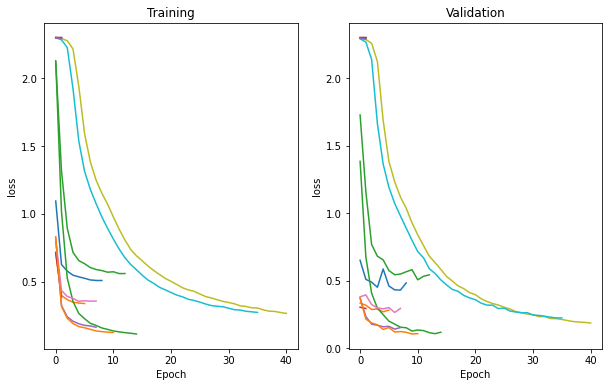

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
for i, tra in enumerate(t_loss):
    ax[0].plot(tra)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')

for i, val in enumerate(v_loss):
    ax[1].plot(val)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')
    
plt.show()

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

{'device': device(type='cuda'), 'dropout': 0.12706427067881337, 'num_epochs': 50, 'learning_rate': 0.0002643832735589233, 'optimizer': 'adam', 'regularization': 0.0010940247433498423}


 20%|████████████████▍                                                                 | 10/50 [07:49<31:18, 46.97s/it]


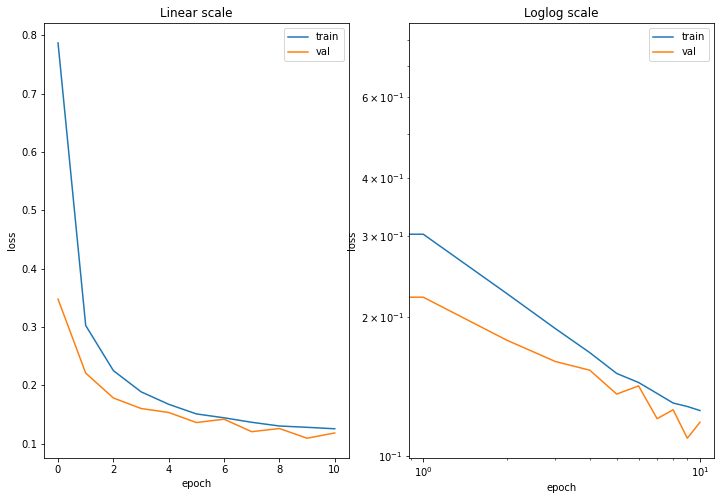

In [32]:
# Best parameter selection
best_par = best_params(params, v_loss)
print(best_par)
net = Net(dropout=best_par['dropout'] ).to(device)
# Loss
loss = nn.CrossEntropyLoss() 
# Optimizer
if best_par['optimizer']=='adam':
    opt = optim.Adam(net.parameters(), lr=best_par['learning_rate'], 
                     weight_decay=best_par['regularization'])
elif best_par['optimizer']=='sgd':
    opt = optim.SGD(net.parameters(), lr=best_par['learning_rate'], 
                    momentum=0.9, weight_decay=best_par['regularization'])

# Training and validation
train_loss, val_loss = net.fit(train_dataloader, val_dataloader, opt, loss, best_par)

# Plotsù
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].plot(train_loss, label='train')
ax[0].plot(val_loss, label='val')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Linear scale')
ax[0].legend()

ax[1].plot(train_loss, label='train')
ax[1].plot(val_loss, label='val')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].set_title('Loglog scale')
ax[1].legend()
ax[1].loglog()

plt.show()

In [33]:
#net.save('best_parameters')

# Testing performances

In [121]:
best_par = {'device': device, 'dropout': 0.12706427067881337, 'num_epochs': 50, 
            'learning_rate': 0.0002643832735589233, 'optimizer': 'adam', 'regularization': 0.0010940247433498423}

net = Net(dropout=best_par['dropout']).to(best_par['device'])

In [122]:
net.load('best_parameters')

In [123]:
test_dataset  = MNIST('classifier_data', 
                     train=False, download=True, transform=initial_transform )

test_load = DataLoader(test_dataset, batch_size=10, shuffle=False)
accuracy = net.test(test_load, best_par['device'])

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.66it/s]


In [124]:
print('Accuracy on test set:', accuracy)

Accuracy on test set: 0.999
